In [72]:
from glob import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal as signal
import cmaps
import os
import scipy.io
import geopandas as gpd
from shapely.geometry import Polygon

matcoastline = scipy.io.loadmat('data/coastline_l.mat')['ncst']
matcoastline = matcoastline[np.where(~np.isnan(matcoastline))[0],:]
matcoastline = gpd.GeoSeries(gpd.points_from_xy(matcoastline[:,0], matcoastline[:,1]))

coastline = gpd.read_file('data/ne_10m_coastline.shp')
polygon = Polygon([(-79.5,7),(-83,2),(-84,-2),(-80,-15),(-73,-20),(-75,-40),(-69,-40),(-69,-18),(-74,-5),(-78,7)])
polygon = gpd.GeoDataFrame([1], geometry=[polygon], crs=coastline.crs)
# polygon.plot(ax=ax)
southcoastline = coastline.clip(polygon)
southcoastline.to_file('~/storage/VECTORIAL/limites/southcoastline.shp')

In [73]:
GEBCO = xr.open_dataset('data/GEBCO/GEBCO_2021_0.05x0.05.nc')
GEBCO = GEBCO.elevation.sel(lat=slice(-40,2),lon=slice(360-150,360-69))
GEBCO['lon'] = GEBCO['lon']%180-180
GEBCO

<xarray.DataArray 'elevation' (lat: 840, lon: 1621)>
[1361640 values with dtype=int16]
Coordinates:
  * lon      (lon) float32 -150.0 -149.9 -149.9 -149.9 ... -69.1 -69.05 -69.0
  * lat      (lat) float32 -39.97 -39.92 -39.88 -39.83 ... 1.875 1.925 1.975
Attributes:
    standard_name:       height_above_mean_sea_level
    long_name:           Elevation relative to sea level
    units:               m
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

In [74]:
glorys12 = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/GLORYS12V1.nc').load().resample({'time':'D'}).mean()
glorys12 = glorys12.rename({'zos':'ssh','zos_anomaly':'ssh_anomaly','zos_synopanom':'ssh_synopanom'})
glorys12



<xarray.Dataset>
Dimensions:        (time: 10227, index: 1281)
Coordinates:
  * time           (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-12-31
  * index          (index) int64 0 1 2 3 4 5 6 ... 1275 1276 1277 1278 1279 1280
    lat            (index) float32 nan nan nan nan ... -39.83 -39.92 -40.0
    lon            (index) float32 -150.0 -149.9 -149.8 -149.8 ... nan nan nan
Data variables:
    sst            (time, index) float32 26.69 26.68 26.66 ... 14.93 14.98 15.13
    ssh            (time, index) float32 0.4451 0.4452 ... 0.08042 0.08049
    ssh_synopanom  (time, index) float32 0.06514 0.06455 ... -0.01093 -0.008316
    ssh_anomaly    (time, index) float32 -0.008695 -0.008073 ... 0.05952 0.05788
    sst_synopanom  (time, index) float64 -0.02423 -0.03087 ... 1.259 1.346
    sst_anomaly    (time, index) float64 0.3005 0.2928 0.2815 ... 0.427 0.5159

In [75]:
reforecasts = xr.open_mfdataset('data/S2S/HOVMOLLERS/*.nc').load()
reforecasts

<xarray.Dataset>
Dimensions:        (index: 110, time: 6120, leadtime: 46)
Coordinates:
  * index          (index) int64 0 1 2 3 4 5 6 7 ... 103 104 105 106 107 108 109
    depth          float64 0.0
    dayofyear      float64 3.0
  * time           (time) datetime64[ns] 2000-01-06 2000-01-09 ... 2021-12-08
  * leadtime       (leadtime) int64 0 1 2 3 4 5 6 7 ... 38 39 40 41 42 43 44 45
    lon            (index) float32 -150.0 -149.0 -148.0 -147.0 ... nan nan nan
    lat            (time, index) float64 nan nan nan nan ... -38.0 -39.0 -40.0
Data variables:
    ssh            (time, leadtime, index) float32 0.3355 0.3336 ... -0.05048
    sst            (time, leadtime, index) float32 24.09 24.13 ... 15.48 14.4
    ssh_anomaly    (time, leadtime, index) float32 -0.08342 ... -0.02131
    sst_anomaly    (time, leadtime, index) float32 -3.629 -3.527 ... -2.539
    sst_synopanom  (time, leadtime, index) float64 -0.09117 0.05801 ... -0.4455
    ssh_synopanom  (time, leadtime, index) float64 0.005094 0.01321 ... -0.05034

In [76]:
try: 
    mask = xr.open_dataset('data/PATHWAY_MASK_REFORECAST_ZOS.nc')
    mask_glorys     = xr.open_dataset('data/PATHWAY_MASK_GLORYS.nc')
except:
    tropicalmask = reforecasts.dslm[0,0,:,:].where(reforecasts.lat>=-2).where(reforecasts.lat<=2)
    tropicalmask = xr.where(~np.isnan(tropicalmask),1,0)

    watermask = reforecasts.dslm[0,0,:,:].fillna(-9999)
    watermask = xr.where(watermask==-9999,1,0)
    coastmask = watermask.where(watermask).bfill('lon',limit=1)
    coastmask = watermask*coastmask
    coastmask = (coastmask==0).where(coastmask.lat<-2).fillna(0)
    coastmask[57,68] = 1
    coastmask[57,69] = 1
    coastmask[53,68] = 1
    coastmask[53,69] = 1
    coastmask[43,76] = 1
    coastmask[42,78] = 1

    tropicalmask_glorys = tropicalmask.reindex({'lon':glorys12.lon, 'lat':glorys12.lat}, method='nearest')
    coastmask_glorys    = coastmask.reindex({'lon':glorys12.lon, 'lat':glorys12.lat}, method='nearest')

    mask = tropicalmask.astype(bool)|coastmask.astype(bool)
    maskglorys = mask.reindex({'lon':glorys12.lon, 'lat':glorys12.lat}, method='nearest')
    xr.merge([mask.to_dataset(name='mask'), tropicalmask.to_dataset(name='tropical_mask'), coastmask.to_dataset(name='coastmask')]).astype(float).load().to_netcdf('data/PATHWAY_MASK_REFORECAST_ZOS.nc')





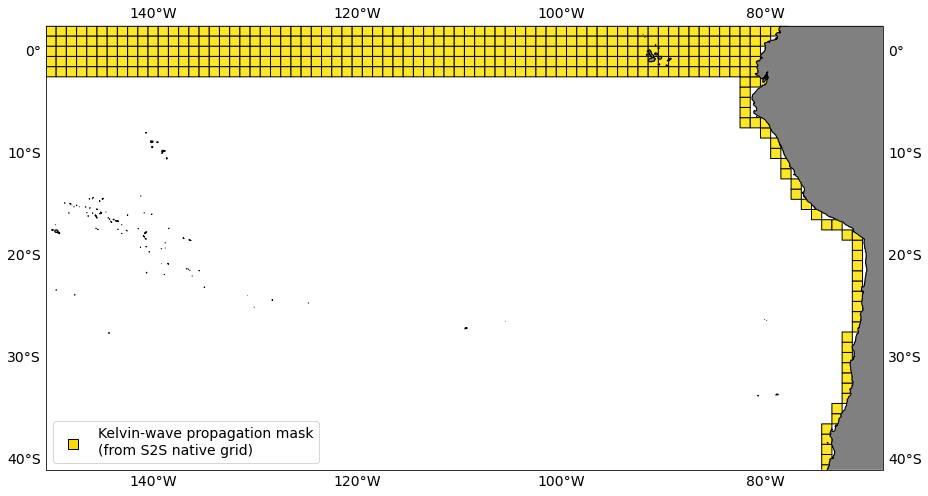

In [77]:
fig = plt.figure(figsize=(15,10))
ax  = fig.add_subplot(111, projection=ccrs.PlateCarree())

# ax.set_extent([-150,-69, -40, 2.5])
ax.set_ylim(-41,2.5)
ax.gridlines(draw_labels=True, linewidth=0)
ax.pcolor(mask.lon,mask.lat,mask.where(mask.mask==1).mask, transform=ccrs.PlateCarree(), cmap='viridis_r', edgecolor='k', lw=1)
ax.scatter([],[], label='Kelvin-wave propagation mask\n(from S2S native grid)', marker='s', color='gold', edgecolor='k', s=100)
ax.add_feature(cf.LAND, zorder=1, color='grey')
ax.coastlines('10m')
ax.legend(loc='lower left')

Text(1100, 2020-08-15 06:00:00, 'Chile')

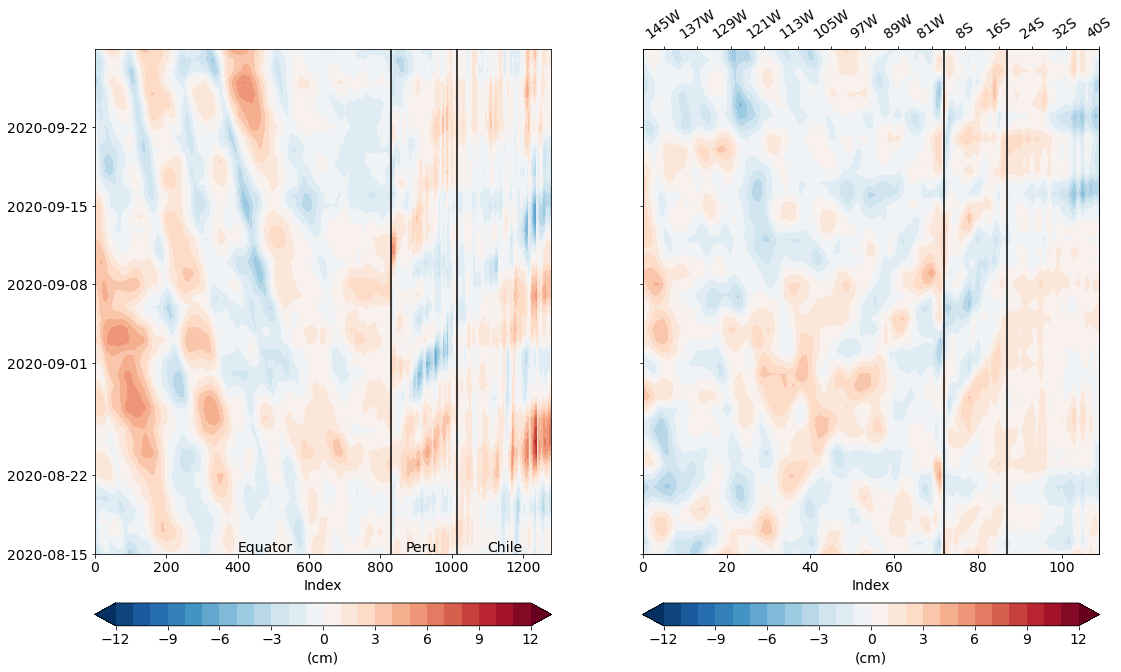

In [247]:
plt.rc('font', size=14)
fig, ax = plt.subplots(1,2, sharey=True, sharex='col', figsize=(18,12))
time = "2020-08-15"
x    = reforecasts.sel(time=time)*100
x.coords['leadtime'] = ('leadtime', [pd.Timedelta(days=l.item())+pd.to_datetime(time) for l in x.leadtime])
y    = glorys12.sel(time=slice(x.leadtime.min(), x.leadtime.max()))*100
labelsx = pd.concat((x.lon.to_series().dropna().map(lambda x: str(int(-x))+'W'),
                    x.lat.to_series().dropna().map(lambda x: str(int(-x))+'S'))).values

labelsy = pd.concat((y.lon.to_series().dropna().map(lambda x: str(int(-x))+'W'),
                    y.lat.to_series().dropna().map(lambda x: str(int(-x))+'S'))).values

var = 'ssh_synopanom'
label = '(cm)'
vmin,vmax = -12,12
step=1
cmap='RdBu_r'
y[var].plot.contourf(ax=ax[0], levels=np.arange(vmin,vmax+step,step),cmap=cmap, extend='both', cbar_kwargs={'orientation':'horizontal','pad':0.075,'label':label})
x[var].plot.contourf(ax=ax[1], levels=np.arange(vmin,vmax+step,step),cmap=cmap, extend='both', cbar_kwargs={'orientation':'horizontal','pad':0.075,'label':label})


for axis in ax:
    axis.set_ylabel('')
    axis.set_xlabel('Index')
    axis.set_title('')
    
ax0 = ax[1].twiny()
ax0.set_xlim(ax[1].get_xlim())
ax0.set_xticks(x.index[5::8])
ax0.set_xticklabels(labelsx[5::8])
ax0.tick_params(axis='x', rotation=35)

ax[0].axvline(831, color='k')
ax[0].axvline(1016, color='k')

ax[1].axvline(72, color='k')
ax[1].axvline(87, color='k')

ax[0].text(400,pd.to_datetime(time)+pd.Timedelta(hours=6),'Equator', transform=ax[0].transData)
ax[0].text(870,pd.to_datetime(time)+pd.Timedelta(hours=6),'Peru', transform=ax[0].transData)
ax[0].text(1100,pd.to_datetime(time)+pd.Timedelta(hours=6),'Chile', transform=ax[0].transData)

Text(1100, 2020-08-15 06:00:00, 'Chile')

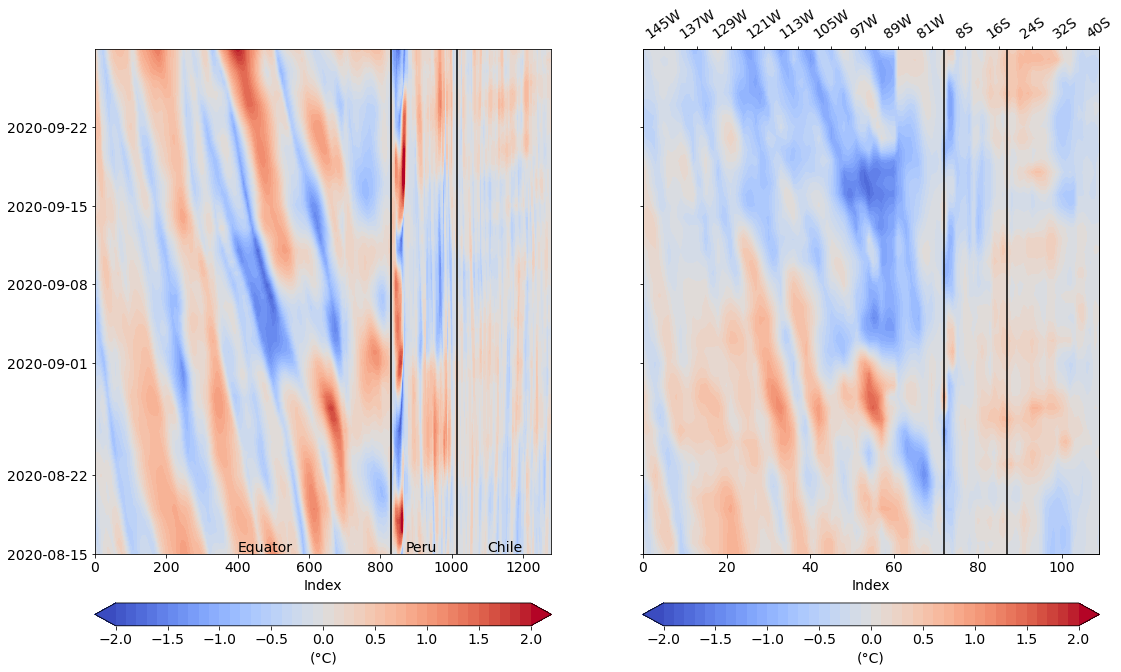

In [249]:
plt.rc('font', size=14)
fig, ax = plt.subplots(1,2, sharey=True, sharex='col', figsize=(18,12))
time = "2020-08-15"
x    = reforecasts.sel(time=time)
x.coords['leadtime'] = ('leadtime', [pd.Timedelta(days=l.item())+pd.to_datetime(time) for l in x.leadtime])
y    = glorys12.sel(time=slice(x.leadtime.min(), x.leadtime.max()))
labelsx = pd.concat((x.lon.to_series().dropna().map(lambda x: str(int(-x))+'W'),
                    x.lat.to_series().dropna().map(lambda x: str(int(-x))+'S'))).values

labelsy = pd.concat((y.lon.to_series().dropna().map(lambda x: str(int(-x))+'W'),
                    y.lat.to_series().dropna().map(lambda x: str(int(-x))+'S'))).values

var = 'sst_synopanom'
label = '(°C)'
vmin,vmax = -2,2
step=0.1
cmap='coolwarm'
y[var].plot.contourf(ax=ax[0], levels=np.arange(vmin,vmax+step,step),cmap=cmap, extend='both', cbar_kwargs={'orientation':'horizontal','pad':0.075,'label':label})
x[var].plot.contourf(ax=ax[1], levels=np.arange(vmin,vmax+step,step),cmap=cmap, extend='both', cbar_kwargs={'orientation':'horizontal','pad':0.075,'label':label})


for axis in ax:
    axis.set_ylabel('')
    axis.set_xlabel('Index')
    axis.set_title('')
    
ax0 = ax[1].twiny()
ax0.set_xlim(ax[1].get_xlim())
ax0.set_xticks(x.index[5::8])
ax0.set_xticklabels(labelsx[5::8])
ax0.tick_params(axis='x', rotation=35)

ax[0].axvline(831, color='k')
ax[0].axvline(1016, color='k')

ax[1].axvline(72, color='k')
ax[1].axvline(87, color='k')

ax[0].text(400,pd.to_datetime(time)+pd.Timedelta(hours=6),'Equator', transform=ax[0].transData)
ax[0].text(870,pd.to_datetime(time)+pd.Timedelta(hours=6),'Peru', transform=ax[0].transData)
ax[0].text(1100,pd.to_datetime(time)+pd.Timedelta(hours=6),'Chile', transform=ax[0].transData)